Loaded image with shape: (801, 1603, 3)
🔧 Applying Total Variation Denoising (pre-filter)
🔧 Applying Non-Local Means Denoising (pre-filter)

Pixels per cluster:
Cluster 0: 657071 pixels
Cluster 4: 122203 pixels
Cluster 1: 110723 pixels
Cluster 6: 97372 pixels
Cluster 5: 89151 pixels
Cluster 2: 79727 pixels
Cluster 3: 127756 pixels

Average brightness per cluster:
Cluster 0: 33.20
Cluster 1: 126.49
Cluster 2: 118.62
Cluster 3: 127.23
Cluster 4: 87.33
Cluster 5: 88.84
Cluster 6: 163.87

Keeping clusters (based on brightness): [1, 2, 3, 4, 5, 6]
Local variance range: min=0, max=255
Mean variance: 45.85, StdDev: 87.09


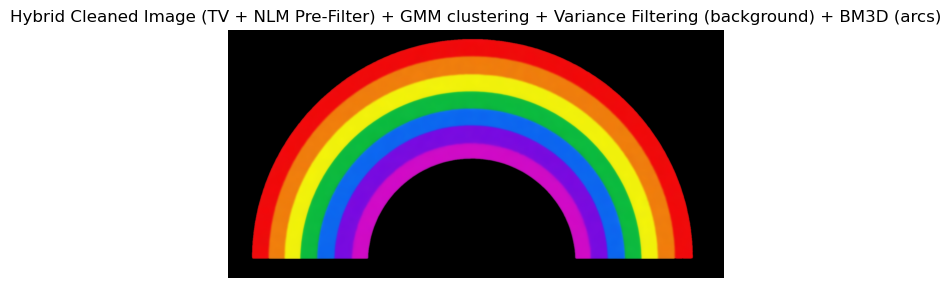

✅ Saved: final_cleaned_image_hybrid_tv_nlm.png


In [19]:
"""
Task 2: Hybrid Pre-filter Denoising Experiment

Description:
    Applies Total Variation (TV) and Non-Local Means (NLM) pre-filters
    before a combined pipeline of Bilateral filtering, Gaussian Mixture Model (GMM)
    clustering, variance-based despeckling, and BM3D denoising.

Function:
    task2_clean_image_gmm_bm3d_hybrid_prefilter_experiment(image: ndarray) -> ndarray

Author: Gregory E. Schwartz
Last Revised: 2025-05-10
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from collections import Counter
from PIL import Image, ImageEnhance
from bm3d import bm3d, BM3DStages
from skimage.restoration import denoise_tv_chambolle

# Load image
image_bgr = cv2.imread('rainbow.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_height, image_width, _ = image_rgb.shape
print(f'Loaded image with shape: {image_rgb.shape}')

# --- Apply TV Denoising as Pre-Filter ---
print("🔧 Applying Total Variation Denoising (pre-filter)")
image_rgb = denoise_tv_chambolle(image_rgb / 255.0, weight=0.1, channel_axis=-1)
image_rgb = (image_rgb * 255).astype('uint8')

# --- Apply NLM Denoising as Pre-Filter ---
print("🔧 Applying Non-Local Means Denoising (pre-filter)")
image_rgb = cv2.fastNlMeansDenoisingColored(image_rgb, None, 10, 10, 7, 21)

# Bilateral filter
bilateral_filtered = cv2.bilateralFilter(image_rgb, d=9, sigmaColor=75, sigmaSpace=75)
pixel_data = bilateral_filtered.reshape((-1, 3))

# GMM clustering
cluster_count = 7
gmm_model = GaussianMixture(n_components=cluster_count, covariance_type='tied', random_state=42)
gmm_model.fit(pixel_data)
cluster_labels = gmm_model.predict(pixel_data)
cluster_centers = gmm_model.means_.astype('uint8')

# Cluster stats
label_counts = Counter(cluster_labels)
print('\nPixels per cluster:')
for label, count in label_counts.items():
    print(f'Cluster {label}: {count} pixels')

brightness = np.mean(image_rgb, axis=2).flatten()
cluster_brightness = {
    label: np.mean(brightness[cluster_labels == label])
    for label in range(cluster_count)
}
print('\nAverage brightness per cluster:')
for label, avg_b in cluster_brightness.items():
    print(f'Cluster {label}: {avg_b:.2f}')

brightness_min = 40
brightness_max = 220
clean_cluster_ids = [label for label, mean_b in cluster_brightness.items()
                     if brightness_min < mean_b < brightness_max]

print(f'\nKeeping clusters (based on brightness): {clean_cluster_ids}')

# Filter by clean clusters
clean_mask = np.isin(cluster_labels, clean_cluster_ids)
cleaned_pixels = np.where(clean_mask[:, np.newaxis], pixel_data, [0, 0, 0])
cleaned_image = cleaned_pixels.reshape((image_height, image_width, 3))

# Variance filtering
gray_image = cv2.cvtColor(cleaned_image.astype('uint8'), cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
squared = cv2.GaussianBlur(gray_image**2, (5, 5), 0)
local_variance = squared - blurred**2
variance_threshold = 255
speckle_mask = local_variance > variance_threshold

final_cleaned = cleaned_image.copy()
final_cleaned[speckle_mask] = [0, 0, 0]

# Diagnostic stats
print(f'Local variance range: min={local_variance.min()}, max={local_variance.max()}')
print(f'Mean variance: {local_variance.mean():.2f}, StdDev: {local_variance.std():.2f}')

# BM3D denoising
normalized = final_cleaned.astype(np.float32) / 255.0
sigma_psd = 30 / 255
bm3d_denoised = bm3d(normalized, sigma_psd, stage_arg=BM3DStages.ALL_STAGES)
bm3d_denoised = (bm3d_denoised * 255).astype(np.uint8)

# Hybrid output: BM3D for arcs, variance-filtered background
rainbow_mask = np.any(final_cleaned > 10, axis=2)
hybrid_image = final_cleaned.copy()
hybrid_image[rainbow_mask] = bm3d_denoised[rainbow_mask]

# Display and save
plt.imshow(hybrid_image)
plt.title("Hybrid Cleaned Image (TV + NLM Pre-Filter) + GMM clustering + Variance Filtering (background) + BM3D (arcs)")
plt.axis('off')
plt.show()

Image.fromarray(hybrid_image.astype('uint8')).save('33final_cleaned_image_hybrid_tv_nlm.png')
print("✅ Saved: final_cleaned_image_hybrid_tv_nlm.png")
